In [29]:
# File Directory 
import glob
import os
from os.path import isdir, join
from pathlib import Path

# Math
import numpy as np
from scipy.fftpack import fft
from scipy import signal
from scipy.io import wavfile
import librosa

# Dimension Reduction
from sklearn.decomposition import PCA

# Visualization
import matplotlib.pyplot as plt
import seaborn as sns
import IPython.display as ipd
import librosa.display
import plotly.offline as py
import plotly.graph_objs as go
import plotly.tools as tls

# Data Pre-processing
import pandas as pd
from sklearn.model_selection import train_test_split

# Deep Learning
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras.layers import Dense, Dropout, Flatten
from tensorflow.keras import Input, layers
from tensorflow.keras import backend as K

# Configuration
py.init_notebook_mode(connected=True)

%matplotlib inline

In [30]:
path = "/home/alexm/Datasets/gunshot_data/gunshot"
files = os.listdir(path)
file_names = []
samples=[]
sample_rates=[]
labels=[]
        
for filename in glob.glob(os.path.join(path, '*.wav')):
    try:
        file_names.append(filename)
        sample_rate, sample = wavfile.read(filename)
        sample = sample[:, 0]
        
        for i in range(0,len(sample)-30000,10000):
            samp0=sample[i:i+30000]
            lab=2
            if (np.max(abs(samp0)) < 500.0):
                lab=0
            
            samples.append(samp0)
            sample_rates.append(sample_rate)
            labels.append(lab)
            
    except:
        pass
    
path = "/home/alexm/Datasets/gunshot_data/glassbreak"
files = os.listdir(path)
for filename in glob.glob(os.path.join(path, '*.wav')):
    try:
        file_names.append(filename)
        sample_rate, sample = wavfile.read(filename)
        sample = sample[:, 0]
        
        for i in range(0,len(sample)-30000,10000):
            samp0=sample[i:i+30000]
            lab=1
            if (np.max(abs(samp0)) < 500.0):
                lab=0
            
            samples.append(samp0)
            sample_rates.append(sample_rate)
            labels.append(lab)
                
    except:
        pass

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-packages/scipy/io/wavfile.py:273: WavFileWarning:

Chunk (non-data) not understood, skipping it.

/usr/lib/python3.7/site-

In [31]:
def log_specgram(audio, sample_rate, window_size=20,
                 step_size=10, eps=1e-10):
    nperseg = int(round(window_size * sample_rate / 1e3))
    noverlap = int(round(step_size * sample_rate / 1e3))
    freqs, times, spec = signal.spectrogram(audio,
                                    fs=sample_rate,
                                    window='hann',
                                    nperseg=nperseg,
                                    noverlap=noverlap,
                                    detrend=False)
    return freqs, times, np.log(spec.T.astype(np.float32) + eps)

Text(0.5, 0, 'Seconds')

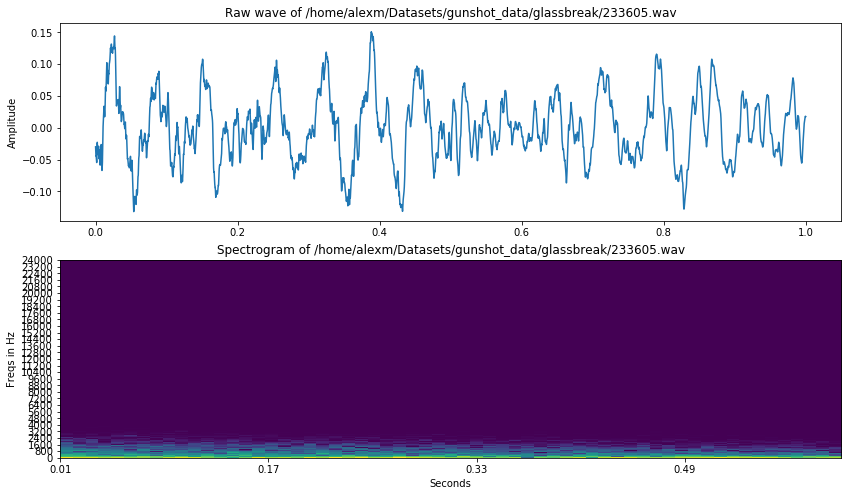

In [32]:
i=15
samp=samples[i]
sr=sample_rates[i]

freqs, times, spectrogram = log_specgram(samp, sr)

fig = plt.figure(figsize=(14, 8))
ax1 = fig.add_subplot(211)
ax1.set_title('Raw wave of ' + filename)
ax1.set_ylabel('Amplitude')
ax1.plot(np.linspace(0, 1,samp.size), samp)

ax2 = fig.add_subplot(212)
ax2.imshow(spectrogram.T, aspect='auto', origin='lower', 
           extent=[times.min(), times.max(), freqs.min(), freqs.max()])
ax2.set_yticks(freqs[::16])
ax2.set_xticks(times[::16])
ax2.set_title('Spectrogram of ' + filename)
ax2.set_ylabel('Freqs in Hz')
ax2.set_xlabel('Seconds')

In [33]:
i=2
samp=samples[i]
sr=sample_rates[i]
print(labels[i])
ipd.Audio(samp, rate=sr)

0


In [34]:
train_wav, test_wav, train_label, test_label = train_test_split(samples, labels, 
                                                                    test_size=0.2,
                                                                    random_state = 1993,
                                                                   shuffle=True)

In [35]:
# Parameters
lr = 0.001
generations = 20000
num_gens_to_wait = 250
batch_size = 256
drop_out_rate = 0.2
input_shape = (30000,1)

In [36]:
#For Conv1D add Channel
train_wav = np.array(train_wav)
test_wav = np.array(test_wav)
train_wav = train_wav.reshape(-1,30000,1)
test_wav = test_wav.reshape(-1,30000,1)
train_label = keras.utils.to_categorical(train_label, 3)
test_label = keras.utils.to_categorical(test_label, 3)

In [37]:
print(train_wav.shape)

(1697, 30000, 1)


In [38]:
input_tensor = Input(shape=input_shape)

x = layers.Conv1D(8, 11, padding='valid', activation='relu', strides=1)(input_tensor)
x = layers.MaxPooling1D(2)(x)
x = layers.Conv1D(16, 7, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(4)(x)
x = layers.Conv1D(32, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(4)(x)
x = layers.Conv1D(64, 5, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(6)(x)
x = layers.Conv1D(128, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(6)(x)
x = layers.Conv1D(256, 3, padding='valid', activation='relu', strides=1)(x)
x = layers.MaxPooling1D(6)(x)
x = layers.Flatten()(x)
x = layers.Dense(100, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(50, activation='relu')(x)
x = layers.Dropout(drop_out_rate)(x)
x = layers.Dense(20, activation='relu')(x)
output_tensor = layers.Dense(3, activation='softmax')(x)

model = tf.keras.Model(input_tensor, output_tensor)

model.compile(loss=keras.losses.categorical_crossentropy,
             optimizer=keras.optimizers.Adam(lr = lr),
             metrics=['accuracy'])

In [39]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_4 (InputLayer)         (None, 30000, 1)          0         
_________________________________________________________________
conv1d_15 (Conv1D)           (None, 29990, 8)          96        
_________________________________________________________________
max_pooling1d_15 (MaxPooling (None, 14995, 8)          0         
_________________________________________________________________
conv1d_16 (Conv1D)           (None, 14989, 16)         912       
_________________________________________________________________
max_pooling1d_16 (MaxPooling (None, 3747, 16)          0         
_________________________________________________________________
conv1d_17 (Conv1D)           (None, 3743, 32)          2592      
_________________________________________________________________
max_pooling1d_17 (MaxPooling (None, 935, 32)           0         
__________

In [40]:
model.fit(train_wav, train_label, validation_data=[test_wav, test_label],
          batch_size=batch_size, 
          epochs=50,
          verbose=1)

Train on 1697 samples, validate on 425 samples
Epoch 1/50
1697/1697 [==============================] - 5s 3ms/sample - loss: 4.6051 - acc: 0.4478 - val_loss: 3.3583 - val_acc: 0.5035
Epoch 2/50
1697/1697 [==============================] - 3s 2ms/sample - loss: 3.8608 - acc: 0.4761 - val_loss: 2.5269 - val_acc: 0.5576
Epoch 3/50
1697/1697 [==============================] - 3s 2ms/sample - loss: 2.7445 - acc: 0.5963 - val_loss: 1.3413 - val_acc: 0.7247
Epoch 4/50
1697/1697 [==============================] - 3s 2ms/sample - loss: 2.3290 - acc: 0.6895 - val_loss: 1.7837 - val_acc: 0.7788
Epoch 5/50
1697/1697 [==============================] - 3s 2ms/sample - loss: 1.7562 - acc: 0.7283 - val_loss: 1.0014 - val_acc: 0.7741
Epoch 6/50
1697/1697 [==============================] - 3s 2ms/sample - loss: 1.1860 - acc: 0.7549 - val_loss: 0.7190 - val_acc: 0.8071
Epoch 7/50
1697/1697 [==============================] - 3s 2ms/sample - loss: 1.4163 - acc: 0.7749 - val_loss: 0.9516 - val_acc: 0.8329
E

In [41]:
Y_test_pred = model.predict(test_wav)
y_classes = Y_test_pred.argmax(axis=-1)
y_test= test_label.argmax(axis=-1)
wrong_examples = np.nonzero(y_classes != y_test)

In [42]:
print(wrong_examples)

(array([ 15, 104, 111, 113, 138, 160, 192, 205, 236, 251, 253, 265, 273,
       279, 289, 292, 309, 324, 325, 333, 336, 346, 352, 362, 386, 387,
       393, 396, 405, 406, 413, 421]),)


In [43]:
i=2
samp=np.reshape(test_wav[i],30000,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

0 [0.97687554 0.02044664 0.0026778 ]


In [44]:
i=10
samp=np.reshape(test_wav[i],30000,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

0 [0.9480756  0.04519295 0.00673138]


In [45]:
i=44
samp=np.reshape(test_wav[i],30000,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

2 [1.7523395e-06 3.4633723e-07 9.9999785e-01]


In [46]:
i=60
samp=np.reshape(test_wav[i],30000,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

2 [0. 0. 1.]


In [47]:
i=20
samp=np.reshape(test_wav[i],30000,)
sr=sample_rates[i]
print(y_test[i],Y_test_pred[i])
ipd.Audio(samp, rate=sr)

2 [0. 0. 1.]
